In [2]:
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logger
import numpy as np
from experiments.dbconnection import DBConnector
from experiments.util import learner, get_dataset_reader

In [3]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'test.log')
setup_logger(log_path=log_path)
logger = logging.getLogger('Test')
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
dataset = "mnist_dc"
dataset_type = "unique"
schema = 'masterthesis'

In [4]:
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)

In [5]:
self.get_job_for_id(job_id=219, cluster_id=5533)

Jobs found 
job_id => 219
fold_id => 3
dataset => synthetic_dc
learner => feta_dc
experiment_schema => results
experiment_table => discrete_choice
dataset_params => {'dataset_type': 'hypervolume', 'n_test_instances': 100000, 'n_train_instances': 10000, 'n_features': 2, 'n_objects': 10}
fit_params => {'epochs': 500, 'callbacks': {'DebugOutput': {'delta': 200}, 'LRScheduler': {'epochs_drop': 200, 'drop': 0.1}}}
learner_params => {'add_zeroth_order_model': 'TRUE'}
hp_ranges => {'feta_dc': {'n_hidden': [2, 20], 'n_units': [20, 40], 'learning_rate': [1e-05, 0.01, 'log-uniform'], 'reg_strength': [1e-10, 0.1, 'log-uniform'], 'batch_size': [128, 1024]}, 'LRScheduler': {'epochs_drop': [100, 250], 'drop': [0.01, 0.5, 'log-uniform']}}
hp_fit_params => {}
hp_iters => 50
is_gpu => True
seed => 42
inner_folds => 1
duration => 5D
learning_problem => discrete_choice
validation_loss => None
hash_value => 111584636f7816fa82e41a7ec3ab73623d4e9198
job_allocated_time => 2018-08-10 16:00:10.363999

Job with

In [26]:
self.init_connection(cursor_factory=None)
job_id = 89
update_result = "INSERT INTO results.discrete_choice (job_id, cluster_id, CategoricalAccuracy, CategoricalTopK2, CategoricalTopK3, CategoricalTopK4, CategoricalTopK5, CategoricalTopK6) VALUES (89, 6285379, 0.9615, 0.9770, 0.9824, 0.9867, 0.9895, 0.9916)"

self.cursor_db.execute(update_result)
if self.cursor_db.rowcount == 1:
    print("Results inserted for the job {}".format(job_id))
self.close_connection()

Results inserted for the job 89


In [6]:
self.init_connection()
avail_jobs = '{}.avail_jobs'.format(schema)
self.cursor_db.execute("SELECT * from {} where job_id={}".format(avail_jobs, 102))
job_desc = self.cursor_db.fetchall()
job_desc = dict(job_desc[0])
print(job_desc)
query_job_id = job_desc['job_id']
del job_desc['job_id']
learner, learner_params  = job_desc['learner'], job_desc['learner_params']
dataset, dataset_type = job_desc['dataset'], job_desc['dataset_params']['dataset_type']
print(learner_params)
fold_id = 1
select_job = "SELECT job_id, learner_params from {} where fold_id = {} AND learner = \'{}\' AND " \
            "dataset = \'{}\' AND dataset_params->>'dataset_type' = \'{}\'".format(avail_jobs, fold_id,
                                                                                            learner, dataset,
                                                                                            dataset_type)
print("Select job for duplication {}".format(select_job))
self.cursor_db.execute(select_job)
new_job_id = None
if self.cursor_db.rowcount != 0:
    query = self.cursor_db.fetchone()
    if learner_params == query['learner_params']:
        new_job_id = query['job_id']
        print("The job {} with fold {} already exist".format(new_job_id, fold_id))
if new_job_id is None:
    keys = list(job_desc.keys())
    columns = ', '.join(keys)
    index = keys.index('fold_id')
    keys[index] = str(fold_id)
    values_str = ', '.join(keys)
    insert_job = "INSERT INTO {0} ({1}) SELECT {2} FROM {0} where {0}.job_id = {3} RETURNING job_id".format(
        avail_jobs, columns, values_str, query_job_id)
    print("Inserting job with new fold: {}".format(insert_job))
    self.cursor_db.execute(insert_job)
    new_job_id = self.cursor_db.fetchone()[0]

print("Job {} with fold id {} updated/inserted".format(new_job_id, fold_id))

{'job_id': 102, 'fold_id': 0, 'dataset': 'synthetic_dc', 'learner': 'feta_dc', 'experiment_schema': 'results', 'experiment_table': 'discrete_choice', 'dataset_params': {'dataset_type': 'hypervolume', 'n_test_instances': 100000, 'n_train_instances': 10000, 'n_features': 2, 'n_objects': 10}, 'fit_params': {'epochs': 500, 'callbacks': {'DebugOutput': {'delta': 200}, 'LRScheduler': {'epochs_drop': 200, 'drop': 0.1}}}, 'learner_params': {'add_zeroth_order_model': 'TRUE'}, 'hp_ranges': {'feta_dc': {'n_hidden': [2, 20], 'n_units': [20, 40], 'learning_rate': [1e-05, 0.01, 'log-uniform'], 'reg_strength': [1e-10, 0.1, 'log-uniform'], 'batch_size': [128, 1024]}, 'LRScheduler': {'epochs_drop': [100, 250], 'drop': [0.01, 0.5, 'log-uniform']}}, 'hp_fit_params': {}, 'hp_iters': 50, 'is_gpu': True, 'seed': 42, 'inner_folds': 1, 'duration': '5D', 'learning_problem': 'discrete_choice', 'validation_loss': 'None', 'hash_value': '111584636f7816fa82e41a7ec3ab73623d4e9198', 'job_allocated_time': datetime.dat

In [4]:
self.init_connection()
select_st = "SELECT * FROM {0} WHERE {0}.dataset=\'{1}\' AND dataset_params->>'dataset_type'=\'{2}\'".format(
    '{0}', dataset, dataset_type)
self.cursor_db.execute(select_st.format('pymc3.avail_jobs'))
run_jobs = []
for job in self.cursor_db.fetchall():
    if job['fold_id']==0:
        run_jobs.append(dict(job))
self.cursor_db.execute(select_st.format('masterthesis.avail_jobs'))
for job in self.cursor_db.fetchall():
    if job['fold_id']==0:
        run_jobs.append(dict(job))

In [38]:
df_path = 'test.csv'
MODEL = "aModel"
from csrank.constants import GEV, NLM, PCL, MNL
rows_list = []
N_OBJECTS_ARRAY = np.arange(3, 20)
for job in run_jobs:
    learner_name = job['learner']
    hp_ranges = job["hp_ranges"]
    add_in_name = ''
    if job['learner_params'].get("add_zeroth_order_model", False):
        add_in_name = '_zero'
    eval_results = {MODEL: '{}{}'.format(learner_name, add_in_name)}
    for n in N_OBJECTS_ARRAY:
        eval_results[n] = np.random.rand(1)[0]
    rows_list.append(eval_results)
    if learner_name not in [MNL, PCL]:
        for n_objects in [3, 5, 7, 13, 15]:
            if 'n_nests' in hp_ranges[learner_name]:
                hp_ranges[learner_name]['n_nests'] = [2, np.max([3, int(n_objects / 2) + 1])]
                print(hp_ranges)
        eval_results = {MODEL: '{}{}_optimized'.format(learner_name, add_in_name)}
        for n in N_OBJECTS_ARRAY:
            eval_results[n] = np.random.rand(1)[0]
        rows_list.append(eval_results)
df = pd.DataFrame(rows_list)
df = df.set_index(MODEL).T
df.insert(0, 'Objects',  N_OBJECTS_ARRAY)
df.to_csv(df_path, index=False)
df

{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 3]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 3]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 4]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 7]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 8]}}
{'nested_logit_model': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization

aModel,Objects,paired_combinatorial_logit,generalized_extreme_value,generalized_extreme_value_optimized,multinomial_logit_model,nested_logit_model,nested_logit_model_optimized,ranknet_dc,ranknet_dc_optimized,feta_dc,feta_dc_optimized,fate_dc,fate_dc_optimized,ranksvm_dc,ranksvm_dc_optimized,feta_dc_zero,feta_dc_zero_optimized
3,3,0.007673,0.519001,0.701689,0.625134,0.809790,0.203564,0.294969,0.497309,0.979272,0.122342,0.642475,0.363660,0.072989,0.222863,0.176422,0.938181
4,4,0.186642,0.338343,0.723219,0.143816,0.112630,0.250749,0.870692,0.418525,0.673838,0.721559,0.415323,0.564485,0.618432,0.021765,0.978005,0.312323
5,5,0.158710,0.010400,0.736726,0.814655,0.807995,0.514309,0.373872,0.465996,0.560657,0.496669,0.524501,0.677825,0.104190,0.196219,0.465982,0.682675
6,6,0.191692,0.010023,0.072824,0.533200,0.079392,0.094299,0.412338,0.476072,0.345074,0.067444,0.196976,0.610741,0.884783,0.739198,0.015212,0.830992
7,7,0.463104,0.927262,0.399163,0.757651,0.073654,0.657214,0.281082,0.546669,0.415743,0.354195,0.560253,0.738780,0.986782,0.840662,0.714326,0.299941
8,8,0.443480,0.264455,0.192727,0.691651,0.887552,0.080788,0.722463,0.440278,0.908643,0.363235,0.256721,0.892142,0.939709,0.059261,0.077921,0.984806
9,9,0.700078,0.474631,0.515140,0.426925,0.453136,0.500621,0.168948,0.137939,0.485543,0.107180,0.185987,0.933043,0.252047,0.729499,0.419479,0.434028
10,10,0.507011,0.411053,0.672190,0.828013,0.058736,0.529003,0.249911,0.449516,0.950764,0.044210,0.508774,0.974001,0.896306,0.563107,0.945694,0.189275
11,11,0.479200,0.422658,0.945886,0.571072,0.897613,0.543339,0.712071,0.877810,0.236270,0.350826,0.403482,0.483017,0.908195,0.131869,0.418216,0.349421
12,12,0.261080,0.193467,0.546906,0.067656,0.065778,0.308630,0.437999,0.187557,0.397995,0.288104,0.185589,0.773793,0.262849,0.639002,0.581344,0.129521


In [31]:
df = pd.read_csv(df_path)
df

,Objects,paired_combinatorial_logit,paired_combinatorial_logit_optimized,generalized_extreme_value,generalized_extreme_value_optimized,multinomial_logit_model,multinomial_logit_model_optimized,nested_logit_model,nested_logit_model_optimized,ranknet_dc,ranknet_dc_optimized,feta_dc,feta_dc_optimized,fate_dc,fate_dc_optimized,ranksvm_dc,ranksvm_dc_optimized,feta_dc_zero,feta_dc_zero_optimized
0,3,0.334542,0.745759,0.143301,0.302669,0.960770,0.573841,0.429012,0.112022,0.363135,0.244278,0.049521,0.814273,0.150589,0.248833,0.347361,0.715454,0.904724,0.400459
1,4,0.176129,0.002039,0.091508,0.942269,0.273274,0.358319,0.442459,0.864507,0.982331,0.683012,0.727323,0.991537,0.705881,0.664490,0.475989,0.826989,0.097984,0.981545
2,5,0.832365,0.628150,0.631161,0.293459,0.165713,0.769881,0.329043,0.896628,0.741195,0.018030,0.279380,0.944711,0.474522,0.547178,0.064404,0.789603,0.886032,0.574858
3,6,0.896146,0.446629,0.496637,0.093086,0.314574,0.288972,0.924660,0.843456,0.371468,0.910481,0.629261,0.300153,0.483716,0.120983,0.452849,0.969878,0.241684,0.677906
4,7,0.312140,0.373960,0.117998,0.900610,0.619509,0.271351,0.986320,0.820056,0.468373,0.788141,0.089173,0.376173,0.270568,0.266458,0.493375,0.336702,0.391204,0.723527
5,8,0.074676,0.421638,0.477792,0.341199,0.622704,0.809523,0.741929,0.841939,0.040371,0.182557,0.941594,0.822022,0.161795,0.180578,0.395199,0.389349,0.117881,0.749365
6,9,0.166182,0.515389,0.400294,0.231093,0.844784,0.385017,0.729770,0.807458,0.605507,0.856611,0.621445,0.030776,0.907095,0.042753,0.485967,0.531787,0.036283,0.579765
7,10,0.336234,0.256563,0.875260,0.026791,0.583825,0.663003,0.617590,0.725323,0.614006,0.376816,0.607985,0.619601,0.762022,0.740634,0.816681,0.872050,0.891949,0.085660
8,11,0.690827,0.983807,0.058391,0.157946,0.500169,0.865375,0.567820,0.477856,0.244728,0.671243,0.603307,0.180970,0.887687,0.101982,0.948323,0.733217,0.293799,0.979632
9,12,0.391485,0.283933,0.235294,0.239503,0.640651,0.702854,0.689858,0.852917,0.536861,0.553548,0.254788,0.528496,0.261889,0.615350,0.249105,0.147065,0.191716,0.791612


In [33]:
models_done = list(df.columns)
models_done

['Objects',
 'paired_combinatorial_logit',
 'paired_combinatorial_logit_optimized',
 'generalized_extreme_value',
 'generalized_extreme_value_optimized',
 'multinomial_logit_model',
 'multinomial_logit_model_optimized',
 'nested_logit_model',
 'nested_logit_model_optimized',
 'ranknet_dc',
 'ranknet_dc_optimized',
 'feta_dc',
 'feta_dc_optimized',
 'fate_dc',
 'fate_dc_optimized',
 'ranksvm_dc',
 'ranksvm_dc_optimized',
 'feta_dc_zero',
 'feta_dc_zero_optimized']

In [36]:
for n_objects in [3, 5, 7, 13, 15]:
    print([2, np.max([3, int(n_objects / 2) + 1])])

[2, 3]
[2, 3]
[2, 4]
[2, 7]
[2, 8]


In [47]:
import pandas as pd
df_ = pd.read_csv('scores.csv', index_col=None)
print(len(df_))
df_.head()

100000


,x,y,score
0,0.487035,0.964832,0.202445
1,0.517571,0.325367,0.860106
2,0.906303,0.613380,0.483603
3,0.929999,0.965174,0.226089
4,0.936650,0.692189,0.437663


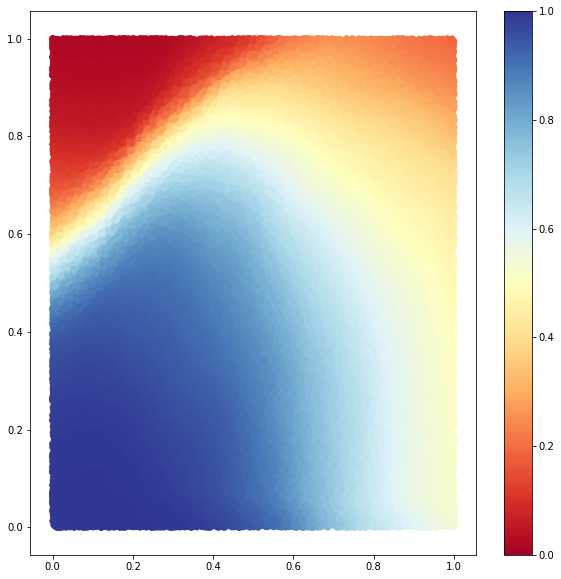

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import numpy as np
%matplotlib inline
values = df_.as_matrix()
fig, ax = plt.subplots(figsize=(10,10))
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.get_cmap('RdYlBu') #get_cmap('Spectral')
colors = np.array([cmap(v) for v in values[:, 2]])
sc = plt.scatter(values[:, 0],values[:, 1], c=values[:, 2], vmin=0, vmax=1, cmap=cmap)
plt.colorbar(sc)
plt.show()